# Mathematical Foundations of Computer Graphics and Vision 2023
## Exercise 1 - Robust Estimation and Optimization

In this exercise you will apply what you learned about robust optimization, especially RANSAC and Iteratively Reweighted Least Squares (IRLS). You will implement RANSAC for circle fitting in the presence of outliers, IRLS for line fitting with $L_1$ norm, and LP for line fitting with $L_1$ and $L_\infty$ norms.

We have implemented a skeleton notebook and you have to fill out blocks marked with `TODO`. Please refrain from modifying the notebook outside of the `START` and `END` blocks for the coding problems apart from new cells you create.

<b style="color:red">Use numpy vectorization</b> instead of python loops where explicitly noted. We may deduct points if your code runs unreasonably slow due (see the "test case" cell). 

In [1]:
%matplotlib inline
import math
from typing import Tuple, List, Optional
import itertools
from collections import namedtuple

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


np.random.seed(123)

## Part 1: RANSAC for circle fitting

In [2]:
# Default parameters
N = 100  # number of total points
D = 10  # half-domain size
tau = 0.1  # inlier distance threshold

### 1.1. Data Generation and Model Fitting

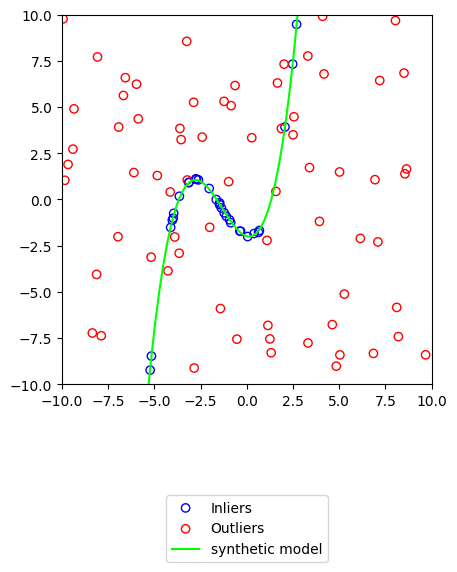

In [3]:
class Polynomial:
    def __init__(self, coefficients):
        self._coefficients = coefficients

    def __repr__(self):
        return f"Polynomial({self._coefficients.tolist()})"
        
    @property
    def degree(self):
        return len(self._coefficients) - 1

    def evaluate(self, x):
        """
        x - (N,1) array with the `x` coordinates

        Returns - (N,1) array with their `y` coordinates 
        """
        y = np.ones_like(x)
        # Use numpy vectorization!
        # START
        p = np.poly1d(np.flip(self._coefficients))
        y=p(x)
        # END
        return y
            # noise_vert=np.random.uniform(-0.1,0.1,x.shape)
# 
    def is_inlier(self, points: np.ndarray, threshold: float = tau):
        """
        points - Nx2 array with the data points

        Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
        """
        is_inlier = np.ones((points.shape[0],), dtype=bool)

        #  : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
        # Use `self.evaluate`
        # Use numpy vectorization!
        # START
        y_pol=self.evaluate(points[:,0])
        diff=np.abs(points[:,1]-y_pol)
        is_inlier=(diff < tau) 

        # END
        return is_inlier
        
    def generate_points(self, r: float, n_points: int = N) -> Tuple[np.ndarray, np.ndarray]:
        """
        r - outlier ratio
        n_points - number of points to generate

        Returns - tuple of inliers and outliers, each defined as an Nx2 array of the respective points
        """
        n_outliers = int(n_points * r)
        n_inliers = n_points - n_outliers

        inliers = np.random.uniform(-D, D, (n_inliers, 2))
        outliers = np.random.uniform(-D, D, (n_outliers, 2))
        
        # print(n_outliers,n_inliers)
        # Implement Task 1.1. Make use of `self.evaluate` and `self.is_inlier` for that
        # START
        
# OUTLIERS 
        is_outlier = ~self.is_inlier(outliers)
        notoutlier=np.sum(~is_outlier)
        outliers = outliers[is_outlier]
        if n_outliers!=outliers.shape[0]:
            outliers_resamp= np.random.uniform(-D, D, (n_outliers, 2))
            is_outlier_resamp = ~self.is_inlier(outliers_resamp)
            outliers_resamp=outliers_resamp[is_outlier_resamp]
            outliers=np.concatenate((outliers,outliers_resamp[:notoutlier]),axis=0)
## INLIERS
        noise_inlier= np.random.uniform(-0.1,0.1,inliers.shape[0])
        inliers_y = self.evaluate(inliers[:,0])+noise_inlier
        inliers = np.column_stack((inliers[:,0], inliers_y))
        out_of_range = np.where(np.abs(inliers[:, 1]) > D)[0]

        while len(out_of_range)>0:
            inliers_new = np.random.uniform(-D, D, (n_inliers, 2))
            inliers_y = self.evaluate(inliers_new[:,0])+noise_inlier
            inliers_new[:, 1] = inliers_y           
            
            inliers[out_of_range]=inliers_new[out_of_range]
            out_of_range = np.where(np.abs(inliers[:, 1]) > D)[0]

        # END 

        return inliers, outliers
    
    @staticmethod
    def fit(points: np.ndarray) -> "Polynomial":
        """
        points - Nx2 array

        Returns - (N-1)-th degree polynomial going through all the `points`
        """
        if points.shape[1] != 2:
            raise ValueError("Bad point dimmensions")

        deg = points.shape[0] - 1

        coefficients = np.zeros(deg + 1)
        
        # : Compute the (N-1)th degree polynomial coefficients that goes through
        #        all the `points` and fill `coefficients`
        # You do not need to handle singular cases - you can just return zeros
        # START 
        
        # coefficients = np.polyfit(points[:, 0], points[:, 1], deg)
        X = np.vander(points[:, 0], deg + 1, increasing=True)
        # Solve for the coefficients using least squares
        Q, R = np.linalg.qr(X)
        coefficients = np.linalg.solve(R, np.dot(Q.T, points[:, 1]))
        
        # END 

        return Polynomial(coefficients)
    
def plot_models(ax, inliers, outliers, synth_model: Polynomial, estimated_model: Optional[Polynomial] = None, title = None):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    if outliers is not None:
        ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')
    
    x = np.linspace(-10, 10, 100)[:, None]
    if estimated_model is not None:
        y = estimated_model.evaluate(x)
        ax.plot(x, y, color='black', label="estimated model")
        
    if title is not None:
        ax.set_title(title)
        
    y = synth_model.evaluate(x)
    ax.plot(x, y, color='lime', label='synthetic model')
    
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")
        # print("OUTLIER PRE",outliers.shape)
        # is_outlier = ~self.is_inlier(outliers)
        # print("OUT" ,is_outlier)
        # notoutlier=np.sum(~is_outlier)
        # print(notoutlier)
        # outliers = outliers[is_outlier]
        # print("OUTLIER PAST",outliers.shape) 
        
        # if n_outliers!=outliers.shape[0]:
        #     print("resample")
        #     outliers_resamp= np.random.uniform(-D, D, (n_outliers, 2))
        #     is_outlier_resamp = ~self.is_inlier(outliers_resamp)
        #     outliers_resamp=outliers_resamp[is_outlier_resamp]
        #     # print(outliers_resamp[:2])
        #     outliers=np.concatenate((outliers,outliers_resamp[:notoutlier]),axis=0)
        # print("OUTLIER PAST Correction",outliers.shape) 

# Plotting the ground truth inliers/outliers 
poly_a = Polynomial(np.array([-2, -0.25, 1, 0.25]))
inliers, outliers = poly_a.generate_points(0.7)
fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_a)
plt.show()
plt.close(fig)

#### Tests and Visualization

There is no need to modify these cells (but read the comments).

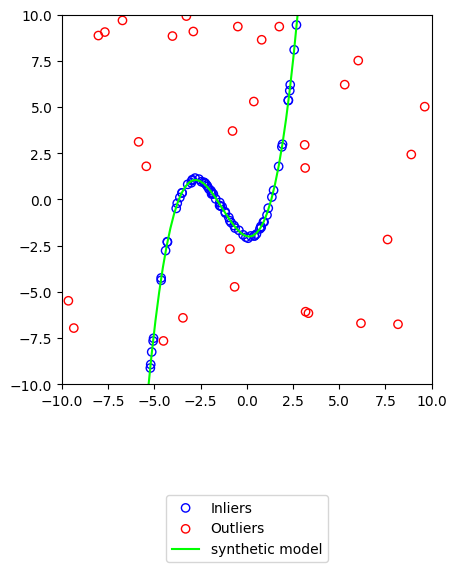

In [4]:
def plot_models(ax, inliers, outliers, synth_model: Polynomial, estimated_model: Optional[Polynomial] = None, title = None):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    if outliers is not None:
        ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')
    
    x = np.linspace(-10, 10, 100)[:, None]
    if estimated_model is not None:
        y = estimated_model.evaluate(x)
        ax.plot(x, y, color='black', label="estimated model")
        
    if title is not None:
        ax.set_title(title)
        
    y = synth_model.evaluate(x)
    ax.plot(x, y, color='lime', label='synthetic model')
    
    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")

# Plotting the ground truth inliers/outliers 
poly_a = Polynomial(np.array([-2, -0.25, 1, 0.25]))
inliers, outliers = poly_a.generate_points(0.3)
fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_a)
plt.show()
plt.close(fig)

In [5]:
%%time
# A simple non-complete test case for the data generation part
# It should not take more than a few seconds to run it.

test_points = np.array([[-5.01341822, -7.11485119],
                        [ 1.86544097,  2.59891622],
                        [-0.37093626, -1.7499924 ],
                        [-7.8621905 , -0.45595404]])

inliers, outliers = poly_a.generate_points(0.5, 1000000)
assert poly_a.is_inlier(inliers).all(), "Bad inliers"
assert (~poly_a.is_inlier(outliers)).all(), "Bad outliers"
assert np.abs(inliers).max() <= D, "Inliers outside of the domain"
assert np.abs(outliers).max() <= D, "Outliers outside of the domain"

assert (poly_a.is_inlier(test_points) == np.array([*([True] * 3), False])).all(), "Failed test case"

CPU times: user 661 ms, sys: 95.7 ms, total: 756 ms
Wall time: 424 ms


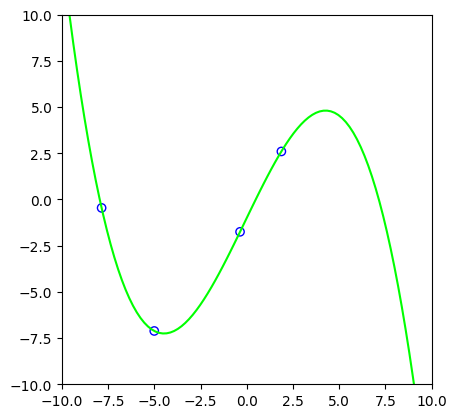

In [6]:
# Visualizing `fit` implementation. No need to edit this
def plot_fitted_poly(points, poly):
    fig, ax = plt.subplots()
    plot_models(ax, points, points[:0], poly)
    ax.get_legend().remove()
    plt.show()
    plt.close(fig)
    
poly = Polynomial.fit(test_points)

plot_fitted_poly(test_points, poly)

### 1.2. RANSAC

In [7]:
def get_ransac_iterations(r: float, sample_size: int, p: float) -> int:
    """
    r - outlier ratio
    sample_size - minimum data
    p - success rate
    
    Returns - number of RANSAC iterations to achieve `p` success rate 
    """
    n = 1
    
    # TODO : Compute the minimum number of RANSAC iterations necessary to achieve `p` success rate
    # START 

    # END 
    n=int(  np.ceil(np.log(1-p)/ (np.log(1- (1-r)**sample_size))  )     )

    return n

In [8]:
def run_ransac(points: np.ndarray, n_iter: int, sample_size: int) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    n_iter - number of ransac iterations
    sample_size - number of samples required to fit the model
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the final Polynomial model
    """

    n_points = points.shape[0]
    inliers = points[:0]
    outliers = points
    poly = None

    
    
    # TODO : Implement 1.2 - RANSAC for model fitting
    # START
    best_inliers = np.array([])
    best_poly = None
    max_inlier_count = 0
    for _ in range(n_iter):
        # Step 1: Randomly select sample_size number of points
        sample_indices = np.random.choice(points.shape[0], size=sample_size, replace=False)
        sample = points[sample_indices]

        # Step 2: Fit a polynomial to these points
        poly_candidate = Polynomial.fit(sample)

        # Step 3: Determine the set of inliers
        candidate_inliers = points[poly_candidate.is_inlier(points, threshold=tau)]

        # Step 4: Keep the model if it has the highest number of inliers so far
        if candidate_inliers.shape[0] > max_inlier_count:
            max_inlier_count = candidate_inliers.shape[0]
            best_inliers = candidate_inliers
            best_poly = poly_candidate

    # Step 6: Refit the model using all the inliers from the best model
    if best_inliers.size > 0:
        final_poly = Polynomial.fit(best_inliers)
    else:
        final_poly = best_poly

    # Determine the outliers
    if final_poly is not None:
        all_inliers_mask = final_poly.is_inlier(points, threshold=tau)
        outliers = points[~all_inliers_mask]
    else:
        outliers = points

    return best_inliers, outliers, final_poly
    # END 
    
    # return inliers, outliers, poly

0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800


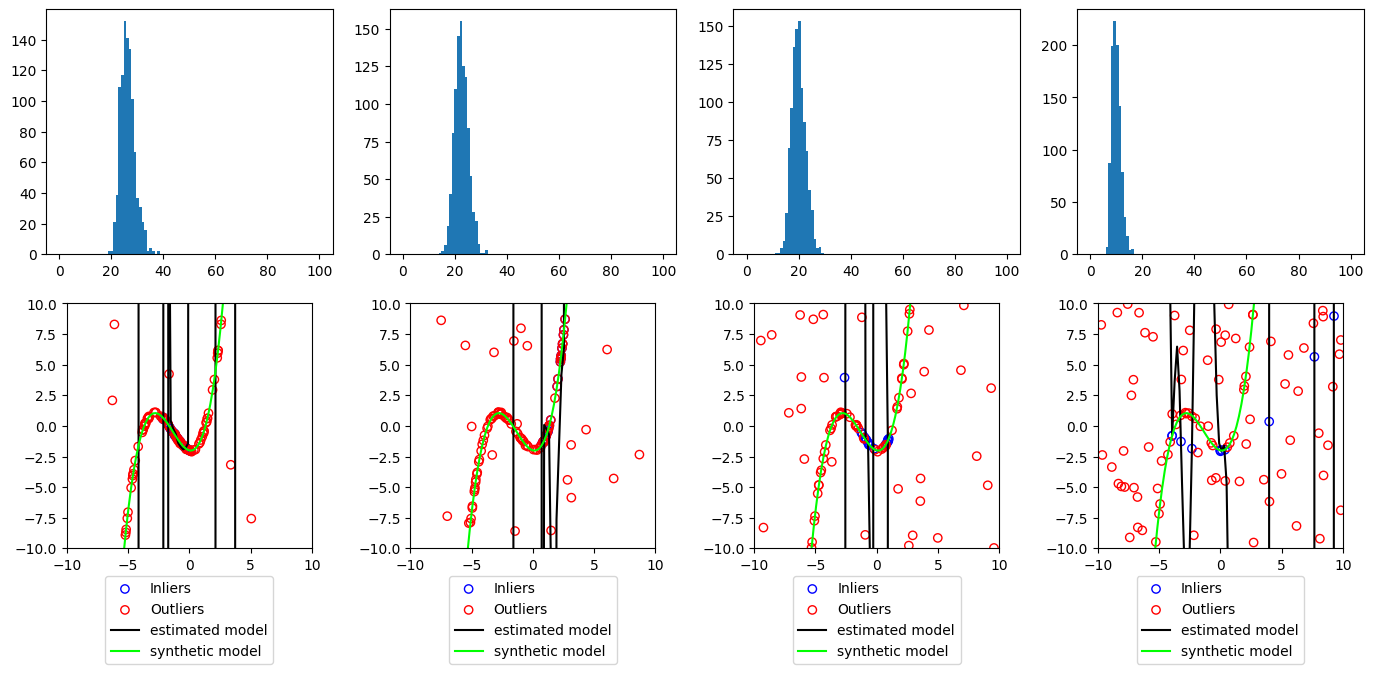

In [18]:
# Running RANSAC and populating historgrams
# It may take some time to run, you can adjust N_RUNS to help with debugging
N_RUNS = 1000
OUTLIER_RATIOS = [0.05, 0.2, 0.3, 0.7]

def plot_ransac_results(synth_poly: Polynomial):
    fig, axes = plt.subplots(2, len(OUTLIER_RATIOS), figsize=(17, 7))

    for r, (ax_hist, ax_vis) in zip(OUTLIER_RATIOS, zip(*axes)): 
        inlier_histogram = np.zeros(N_RUNS)

        ransac_inliers = None
        ransac_outliers = None
        model = None

        # TODO : Fill `inlier_histogram` array and assign `ransac_inliers`,
        #        `ransac_outliers`, `model`
        # START
        for i in range(N_RUNS):
            print(i) if i % 200 == 0 else None
            # Generate synthetic data points
            inliers, outliers = synth_poly.generate_points(r)
            points = np.concatenate((inliers, outliers), axis=0)

            # Run RANSAC
            ransac_inliers_run, ransac_outliers_run, model_run = run_ransac(points, n_iter=100, sample_size=3)

            # Count the inliers and store the result
            inlier_histogram[i] = ransac_inliers_run.shape[0]

            # Optionally, store one of the runs to visualize
            if i == 0:  # Just as an example, take the first run
                ransac_inliers = ransac_inliers_run
                ransac_outliers = ransac_outliers_run
                model = model_run



        # END

        ax_hist.hist(inlier_histogram, range=(0, N), bins=N+1)

        plot_models(ax_vis, ransac_inliers, ransac_outliers, synth_poly, model)

    plt.show()
    plt.close(fig)


plot_ransac_results(poly_a)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


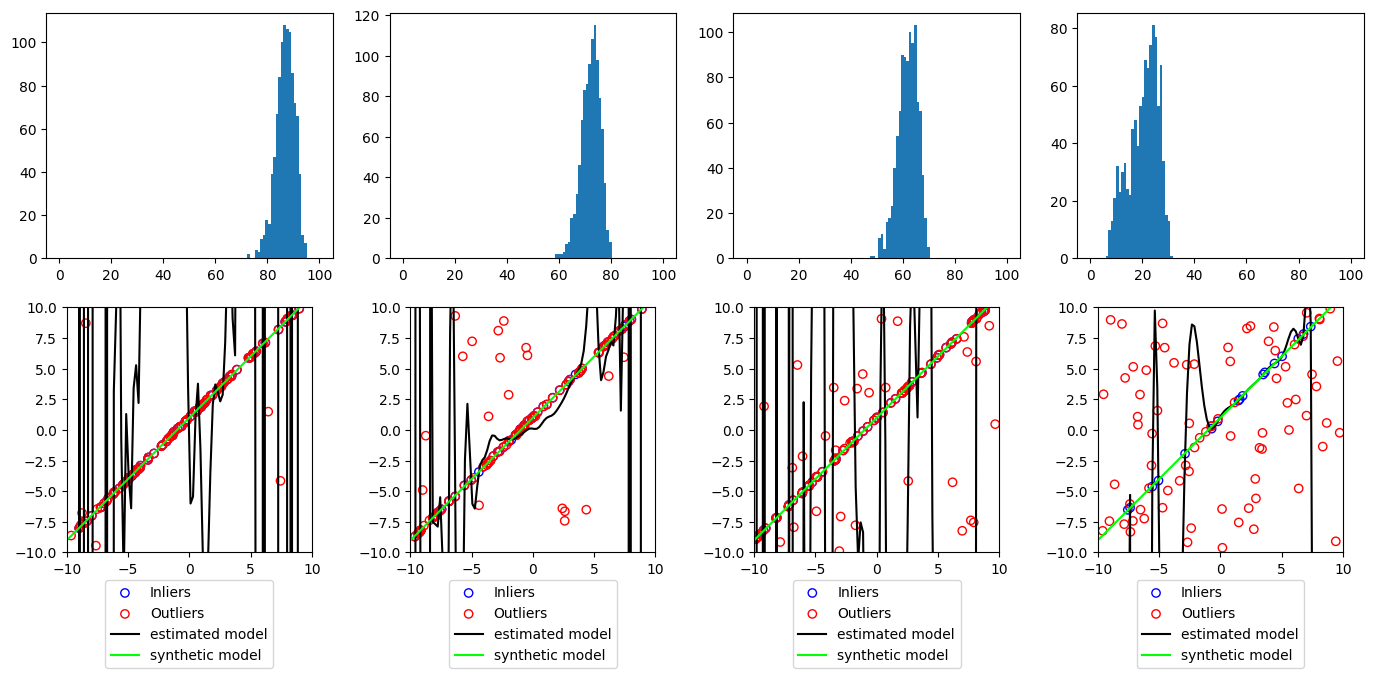

In [10]:
poly_b = Polynomial(np.array([1, 1]))
plot_ransac_results(poly_b)

### 1.3. Exhaustive search

In [11]:
def exhaustive_search(points: np.ndarray, sample_size) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    sample_size - number of samples required to fit the model
    
    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the best model
    """

    n_points = points.shape[0]
    inliers = points[:0]
    outliers = points
    model = None

    # TODO : Implement exhaustive search by trying all the combinations of minimal data points
    # START
    max_inliers_count = -1
    for indices in itertools.combinations(range(n_points), sample_size):
        # Select the sample points based on the current combination of indices
        sample = points[np.array(indices)]
        # Fit a Polynomial model to the sample
        current_model = Polynomial.fit(sample)

        # Check the entire set of points for inliers to this model
        inlier_mask = current_model.is_inlier(points)
        inliers_count = np.sum(inlier_mask)

        # If this model has the most inliers so far, save it and its inliers/outliers
        if inliers_count > max_inliers_count:
            max_inliers_count = inliers_count
            model = current_model
            inliers = points[inlier_mask]
            outliers = points[~inlier_mask]

    return inliers, outliers, model

    # END 
    
    # return inliers, outliers, model

567
Real inliers: 24
RANSAC inliers: 22
Exhaustive search inliers: 24


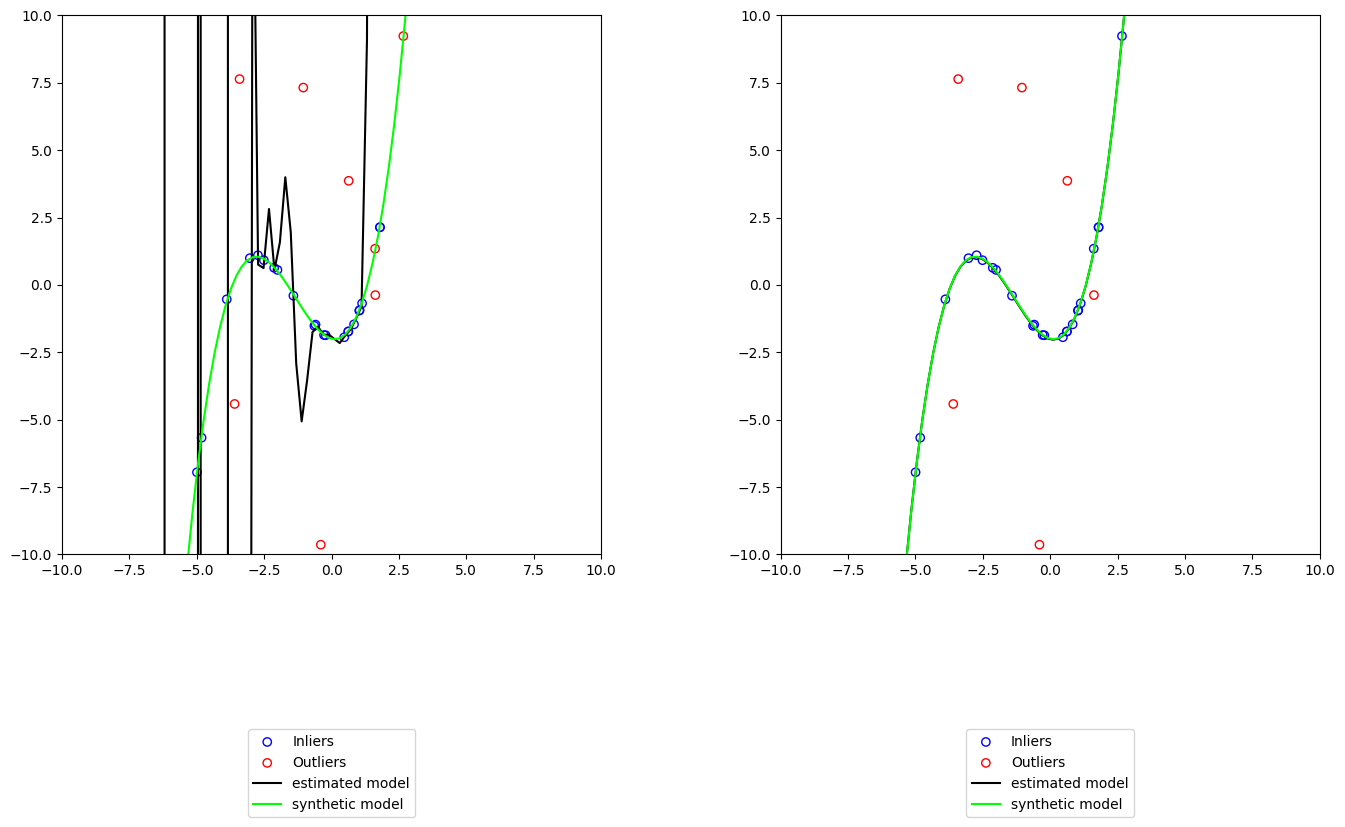

In [12]:
# Running exhaustive search. No need to edit this. Running on a reduced set of points
inliers, outliers = poly_a.generate_points(0.2, 30)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_a.degree + 1
n_iter = get_ransac_iterations(0.7, sample_size, 0.99)
print(n_iter)
ransac_inliers, ransac_outliers, ransac_model = run_ransac(points, n_iter, sample_size)

exhaustive_inliers, exhaustive_outliers, exhaustive_model = exhaustive_search(points, sample_size)

print(f"Real inliers: {len(inliers)}")
print(f"RANSAC inliers: {len(ransac_inliers)}")
print(f"Exhaustive search inliers: {len(exhaustive_inliers)}")

fig, axes = plt.subplots(1, 2, figsize=(17, 7))

plot_models(axes[0], ransac_inliers, ransac_outliers, poly_a, ransac_model)
plot_models(axes[1], exhaustive_inliers, exhaustive_outliers, poly_a, exhaustive_model)

plt.show()
plt.close(fig)

### Questions and Discussion 

<b style="color:red"> Question 1.1: </b> How many combinations (exhaustive search) exist for $N=100$ points? 

For sample size s, there are $\binom{N}{s}$ combinations. For polynomial fitting , it would be s=degree+1. E.g. cubic function fitting: s=4 . So for cubic funtion fitting, we would have  $\binom{100}{4}=3,921,225$ combinations

<b style="color:red"> Question 1.2: </b> What about the number of RANSAC iterations with $r=5\%$, $20\%$, $30\%$ and $70\%$? 

According to the derived formula from the lecture, the number $M$ of RANSAC iterations is calculated as follows: $N=\lceil \frac{log(1-p)}{\log{(1-(1-\epsilon)^s})} \rceil $ Assumong $p=0.99$ and cubic fitting ( $s=4$) we need 
4,9,17 and 567 iteratios for r=0.05,0.2,0.3,0.7 respectively

<b style="color:red"> Question 1.3: </b> What about when $N=100,000$ points?

using the same formula as in question 1.1 , there are $\binom{N}{s}$ combinations. For cubic fitting, there are $\binom{100000}{4}$

<b style="color:red"> Question 1.4: </b> Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?

_TODO_: Your answer here

<b style="color:red"> Question 1.5: </b> Does RANSAC always find close to the optimal number of inliers? Why? If not, would increasing the number of RANSAC iterations always improve that?

_TODO_: Your answer here

<b style="color:red"> Question 1.6: </b> Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.

_TODO_: Your answer here

<b style="color:red"> Question 1.7: </b> One of the challenges in using RANSAC for fitting polynomials is choosing appropriate values for the number of iterations and the inlier threshold. How would you go about selecting these values, and what factors should you consider when making this choice? Describe any tradeoffs that may exist between these two parameters, and provide an example scenario where a higher number of iterations or a higher inlier threshold might be preferable.

_TODO_: Your answer here

## Part 2: IRLS and norms for line fitting

In [13]:
poly_b = Polynomial(np.array([1, 1]))

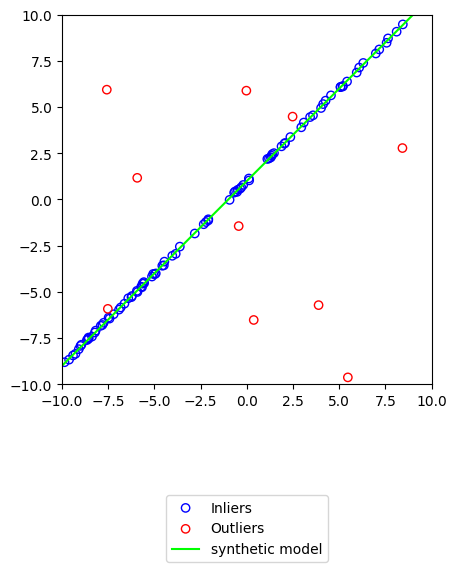

In [14]:
# Plotting the generated line that will be used for model fitting, no need to change this code    
inliers, outliers = poly_b.generate_points(0.1)
points = np.concatenate((inliers, outliers), 0)

fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_b)
plt.show()
plt.close(fig)

In [15]:
## Implement different line fitting algorithms

def fit_line_irls_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    
    line = np.array([0, 0.5])
    # TODO : Implement line fitting with L-1 norm by using IRLS
    # START
    epsilon=0.01
    while True:
        diff = points[:, 1] - line[0] - line[1] * points[:, 0]
        weights= 1/(2*np.abs(diff)  )

        X = np.column_stack((np.ones_like(points[:, 0]), points[:, 0]))
        W = np.diag(weights)
        y = points[:, 1]
        WX =np.dot(W, X) 
        Wy =np.dot(W, y) 

        coeff, esiduals, rank, s = np.linalg.lstsq(WX, Wy, rcond=None)
        
        line_new =coeff# np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y
        # Check for convergence.
        if np.allclose(line, line_new, rtol=0, atol=epsilon):
            break
        
        # Update the line estimate.
        line = line_new
    # END

    return Polynomial(line)


def fit_line_lp_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """   
    n = len(points)
    c = np.hstack([np.zeros(2), np.ones(2 * n)])  # Objective function

    A_eq,b_eq = [] ,[] # List to store the constraint matrix rows
    
    for i, (x_i, y_i) in enumerate(points):
        # Initialize a row with zeros for all variables
        row = [0] * (2 + 2 * n)

        row[0:2] = [x_i ,1] # a,b
        row[2 + 2*i] =1     # Coefficient for e_i^+
        row[3 + 2*i] =-1    # Coefficient for e_i^-
        A_eq.append(row)
        b_eq.append(y_i) 

    A_eq ,b_eq= np.array(A_eq) ,np.array(b_eq) #
    bounds = [(None, None), (None, None)] + [(0, None) for _ in range(2 * n)]  # Bounds

    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    a, b = result.x[:2]  # Extract slope and intercept
    return Polynomial(np.array([b, a]))



def fit_line_lp_l_inf(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points
    
    Returns - fitted Line
    """
    # line = np.array([0, 0.5])
    
    # TODO : Implement line fitting with L-infinity norm by using linear programming
    # START
    n = len(points)
    # Objective function to minimize the variable d (maximum deviation)
    c = [0, 0, 1]  # Coefficients for m, b, and d
    
    # Constraint matrix
    A_ub ,b_ub = [],[]
    for x_i, y_i in points:
        # Constraints for points above the line
        A_ub.append([x_i, 1, -1])
        b_ub.append(y_i)
        
        # Constraints for points below the line
        A_ub.append([-x_i, -1, -1])
        b_ub.append(-y_i)
    
    # Bounds for m, b, and d
    bounds = [(None, None), (None, None), (0, None)]
    
    # Solve the linear programming problem
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
    

    m, b = result.x[:2]
    return Polynomial(np.array([b, m]))
    # END

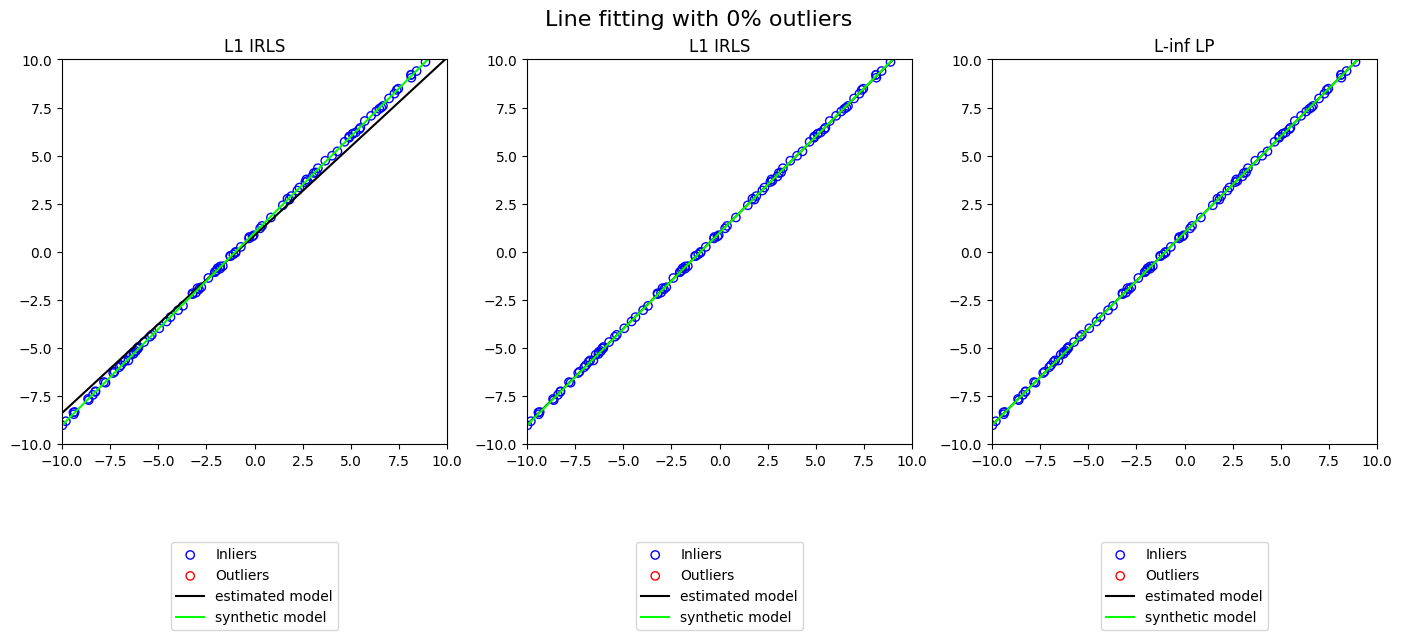

IRLS L1: Polynomial([0.8643332292766364, 0.9229351316383583])
LP L1: Polynomial([1.003273398733718, 0.9974860638382732])
LP L-inf: Polynomial([1.0015142654016365, 0.999384705315918])


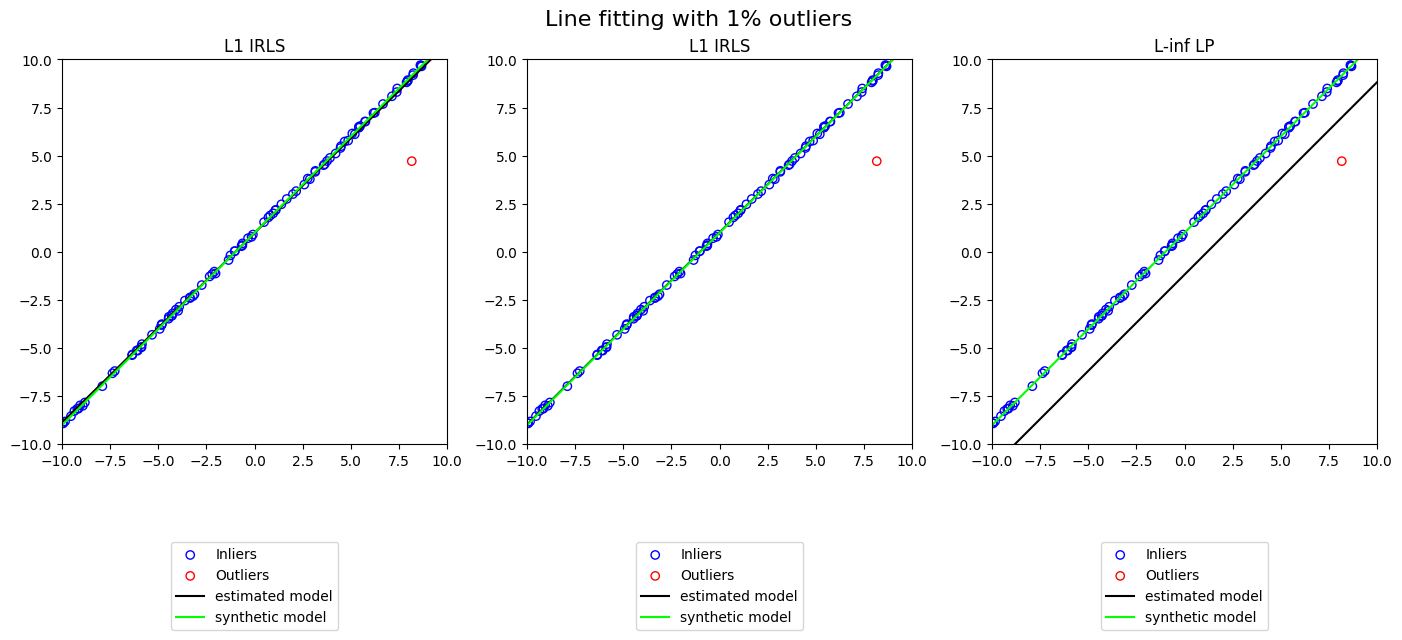

IRLS L1: Polynomial([0.9869536882395548, 0.9843427974205411])
LP L1: Polynomial([1.0169187858898507, 0.9983502338987317])
LP L-inf: Polynomial([-1.1750216142203624, 0.999638520104474])


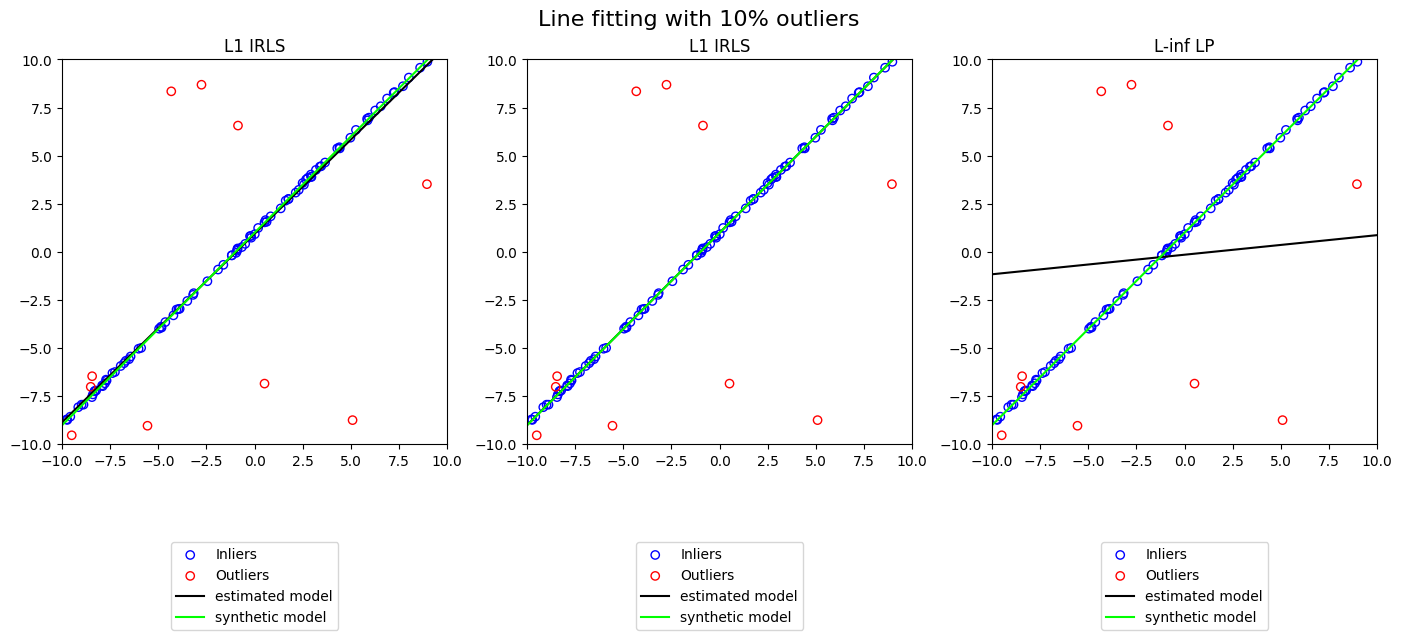

IRLS L1: Polynomial([0.9424540394502638, 0.9787508582827577])
LP L1: Polynomial([0.9969924655720788, 0.9992398812752781])
LP L-inf: Polynomial([-0.14358513338966622, 0.10161528463254631])


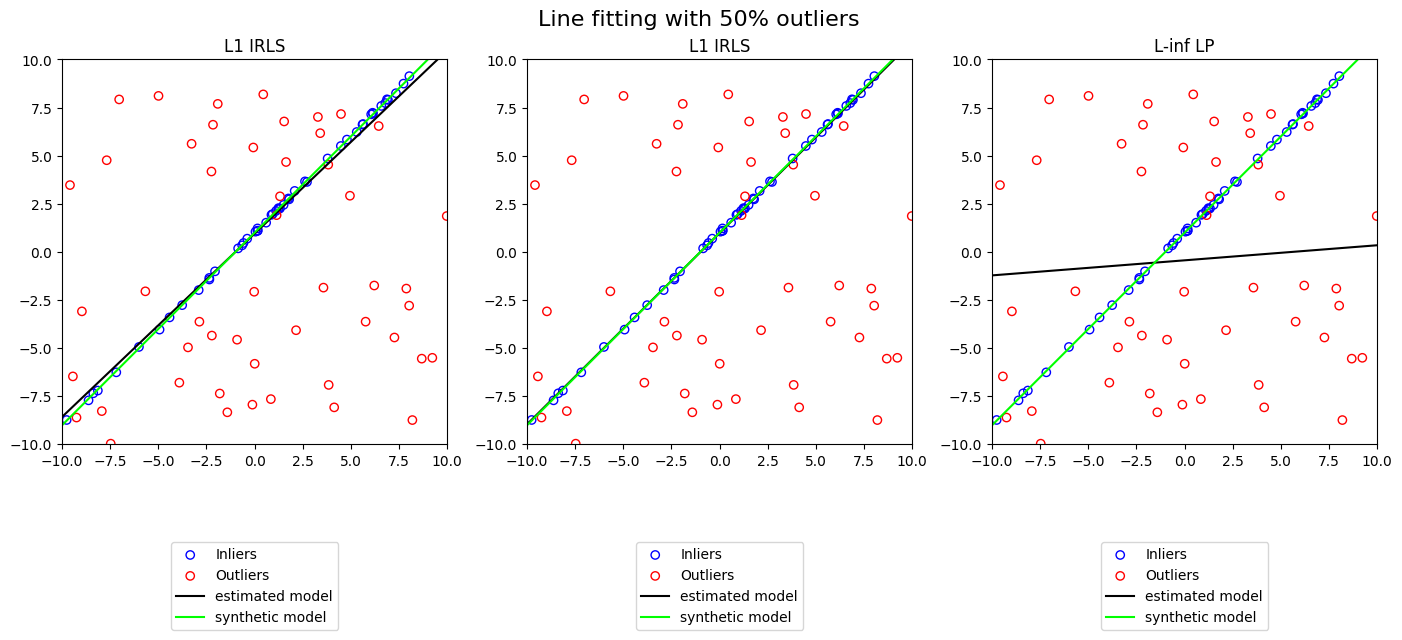

IRLS L1: Polynomial([0.9503085923451192, 0.9517768927127456])
LP L1: Polynomial([0.9863770327862788, 0.9938324861393986])
LP L-inf: Polynomial([-0.4352710092656884, 0.07823746562603145])


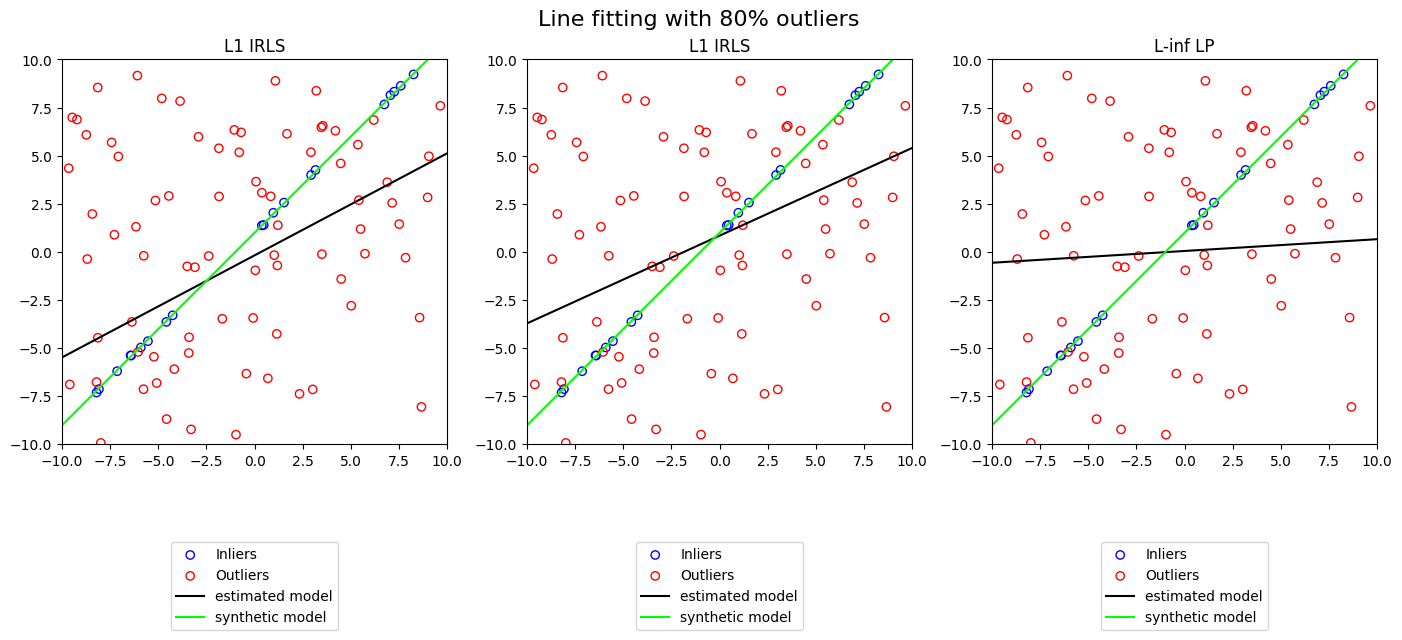

IRLS L1: Polynomial([-0.17669360739143083, 0.5299415642750152])
LP L1: Polynomial([0.8456678490441449, 0.45559147739540573])
LP L-inf: Polynomial([0.0504033834044628, 0.061191301327324664])


In [16]:
# Plotting the results. No need to change this code
for r in [0.0, 0.01, 0.1, 0.5, 0.8]:
    inliers, outliers = poly_b.generate_points(r)
    points = np.concatenate((inliers, outliers), 0)

    irls_l1_line = fit_line_irls_l1(points)
    lp_l1_line = fit_line_lp_l1(points)
    lp_l_inf_line = fit_line_lp_l_inf(points)

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    
    fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
    plot_models(axes[0], inliers, outliers, poly_b, irls_l1_line, title="L1 IRLS")
    plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1 IRLS")
    plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf LP")
    
    plt.show()
    plt.close(fig)


    print(f"IRLS L1: {irls_l1_line}")
    print(f"LP L1: {lp_l1_line}")
    print(f"LP L-inf: {lp_l_inf_line}")


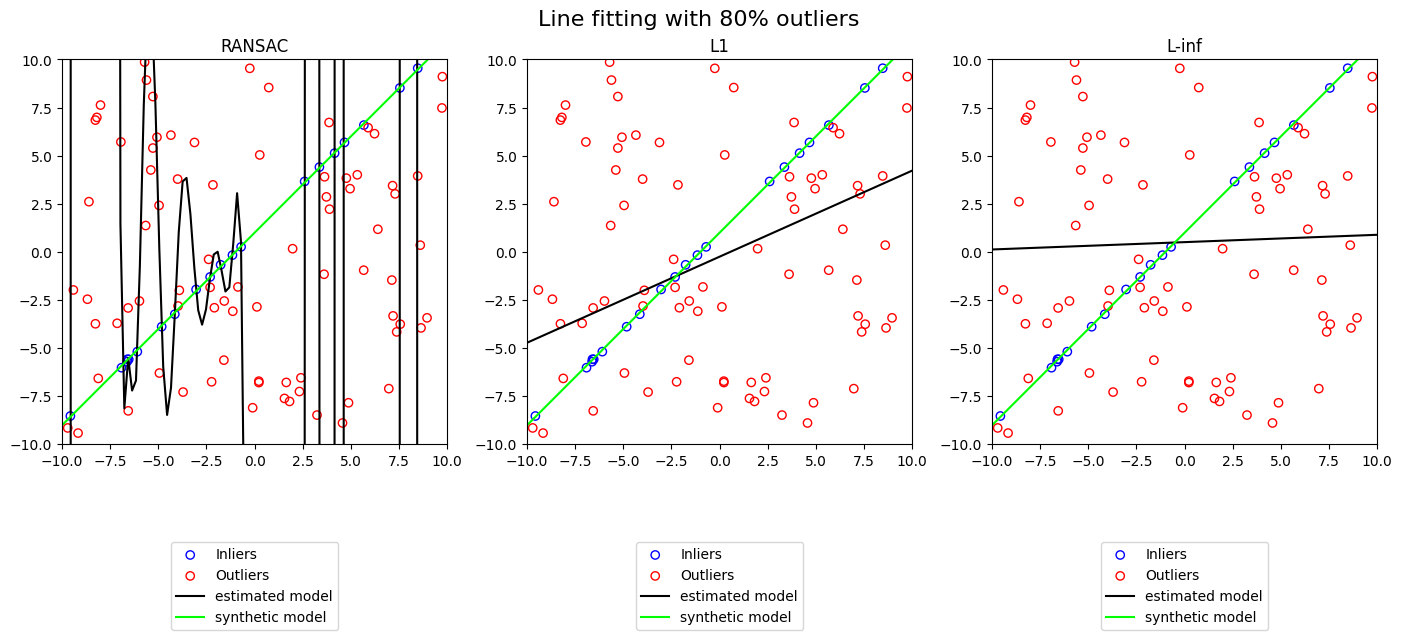

In [17]:
# Comparison with RANSAC
r = 0.8
inliers, outliers = poly_b.generate_points(r)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_b.degree + 1
n_iter = get_ransac_iterations(r, sample_size, 0.99)
_, _, ransac_line = run_ransac(points, n_iter, sample_size)

lp_l1_line = fit_line_lp_l1(points)
lp_l_inf_line = fit_line_lp_l_inf(points)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    
fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)
    
plot_models(axes[0], inliers, outliers, poly_b, ransac_line, title="RANSAC")
plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1")
plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf")
    
plt.show()
plt.close(fig)

### Discussion 

<b style="color:red"> Question 2.1:</b> Discuss the results obtained by IRLS/LP solutions.

We can see that  the model from line-fitting with L1 norm is closer to the synthetic model than with the $L_{\infty}$ norm. In the case of r=0.01 outlier rate, it can be seen that line-fitting with $L_{\infty}$ norm is less robust to outliers.

<b style="color:red"> Question 2.2:</b> Compare and contrast them with RANSAC. What are the key differences between these two approaches? Under what circumstances might one be more suitable than the other?

_TODO_: Your answer here